# Модель на данных application - 3 (выбор модели)

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import helpers
import main_functions

import matplotlib.pyplot as plt

In [3]:
application_df = pd.read_csv('data/application_train.csv')
application_test_df = pd.read_csv('data/application_test.csv')

application_mod_df, qd = main_functions.build_training_data_for_application(application_df)
application_mod_test_df, _ = main_functions.build_training_data_for_application(
    application_df, qd)

bureau = pd.read_csv('data/bureau.csv')
ccb = pd.read_csv('data/credit_card_balance.csv')
pos_cash = pd.read_csv('data/POS_CASH_balance.csv')
application_mod_df['SK_ID_CURR'] = application_df['SK_ID_CURR']
application_mod_test_df['SK_ID_CURR'] = application_test_df['SK_ID_CURR']
application_mod_df, bureau_features = main_functions.add_bureau_features(application_mod_df, bureau)
application_mod_test_df, bureau_features = main_functions.add_bureau_features(application_mod_test_df, bureau)
application_mod_df, ccb_features = main_functions.add_ccb_features(application_mod_df, ccb)
application_mod_test_df, ccb_features = main_functions.add_ccb_features(application_mod_test_df, ccb)
application_mod_df, pos_cash_features = main_functions.add_pos_cash_features(application_mod_df, pos_cash)
application_mod_test_df, pos_cash_features = main_functions.add_pos_cash_features(application_mod_test_df, pos_cash)

X = application_mod_df
y = application_df['TARGET']

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [4]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.33, random_state=57)
X_TRAIN['TARGET'] = Y_TRAIN
X_TEST['TARGET'] = Y_TEST

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
def kfold_lightgbm(train, test, folds_cnt, lgbm_params, real_test=False):
    folds = KFold(n_splits=folds_cnt, shuffle=True, random_state=57)
    train_preds = np.zeros(train.shape[0])
    test_preds = np.zeros(test.shape[0])
    X = train.drop(['TARGET'], axis=1)
    y = train['TARGET']
    for n_fold, (train_index, val_index) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[val_index], y.iloc[val_index]
        clf = lgb.LGBMClassifier(**lgbm_params)
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='auc', verbose=400)
        lgb.plot_importance(clf, figsize=(20,20))
        plt.show()
        train_preds[val_index] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
        if not real_test:
            test_preds += clf.predict_proba(
                test.drop(['TARGET'], axis=1), 
                num_iteration=clf.best_iteration_)[:, 1] / folds_cnt
        else:
            test_preds += clf.predict_proba(
                test, num_iteration=clf.best_iteration_)[:, 1] / folds_cnt
        
        print('Fold {:d}, VALID AUC: {:06.4f}'.format(
            n_fold + 1, roc_auc_score(np.array(y_val), train_preds[val_index])))

    print('Full TRAIN AUC score {}'.format(roc_auc_score(train['TARGET'], train_preds)))
    if not real_test:
        print('TEST AUC score {}'.format(roc_auc_score(test['TARGET'], test_preds)))
    else:
        return helpers.create_submission(test_preds)
        

[400]	training's auc: 0.770611	training's binary_logloss: 0.242818	valid_1's auc: 0.749856	valid_1's binary_logloss: 0.252981
[800]	training's auc: 0.794215	training's binary_logloss: 0.233769	valid_1's auc: 0.763087	valid_1's binary_logloss: 0.247868
[1200]	training's auc: 0.81039	training's binary_logloss: 0.227915	valid_1's auc: 0.768344	valid_1's binary_logloss: 0.245971
[1600]	training's auc: 0.824283	training's binary_logloss: 0.223158	valid_1's auc: 0.770837	valid_1's binary_logloss: 0.245148
[2000]	training's auc: 0.83652	training's binary_logloss: 0.218972	valid_1's auc: 0.771821	valid_1's binary_logloss: 0.244806
[2400]	training's auc: 0.84729	training's binary_logloss: 0.215157	valid_1's auc: 0.772761	valid_1's binary_logloss: 0.244524
[2800]	training's auc: 0.857074	training's binary_logloss: 0.211598	valid_1's auc: 0.77351	valid_1's binary_logloss: 0.244327
[3200]	training's auc: 0.866043	training's binary_logloss: 0.208202	valid_1's auc: 0.773814	valid_1's binary_logloss:

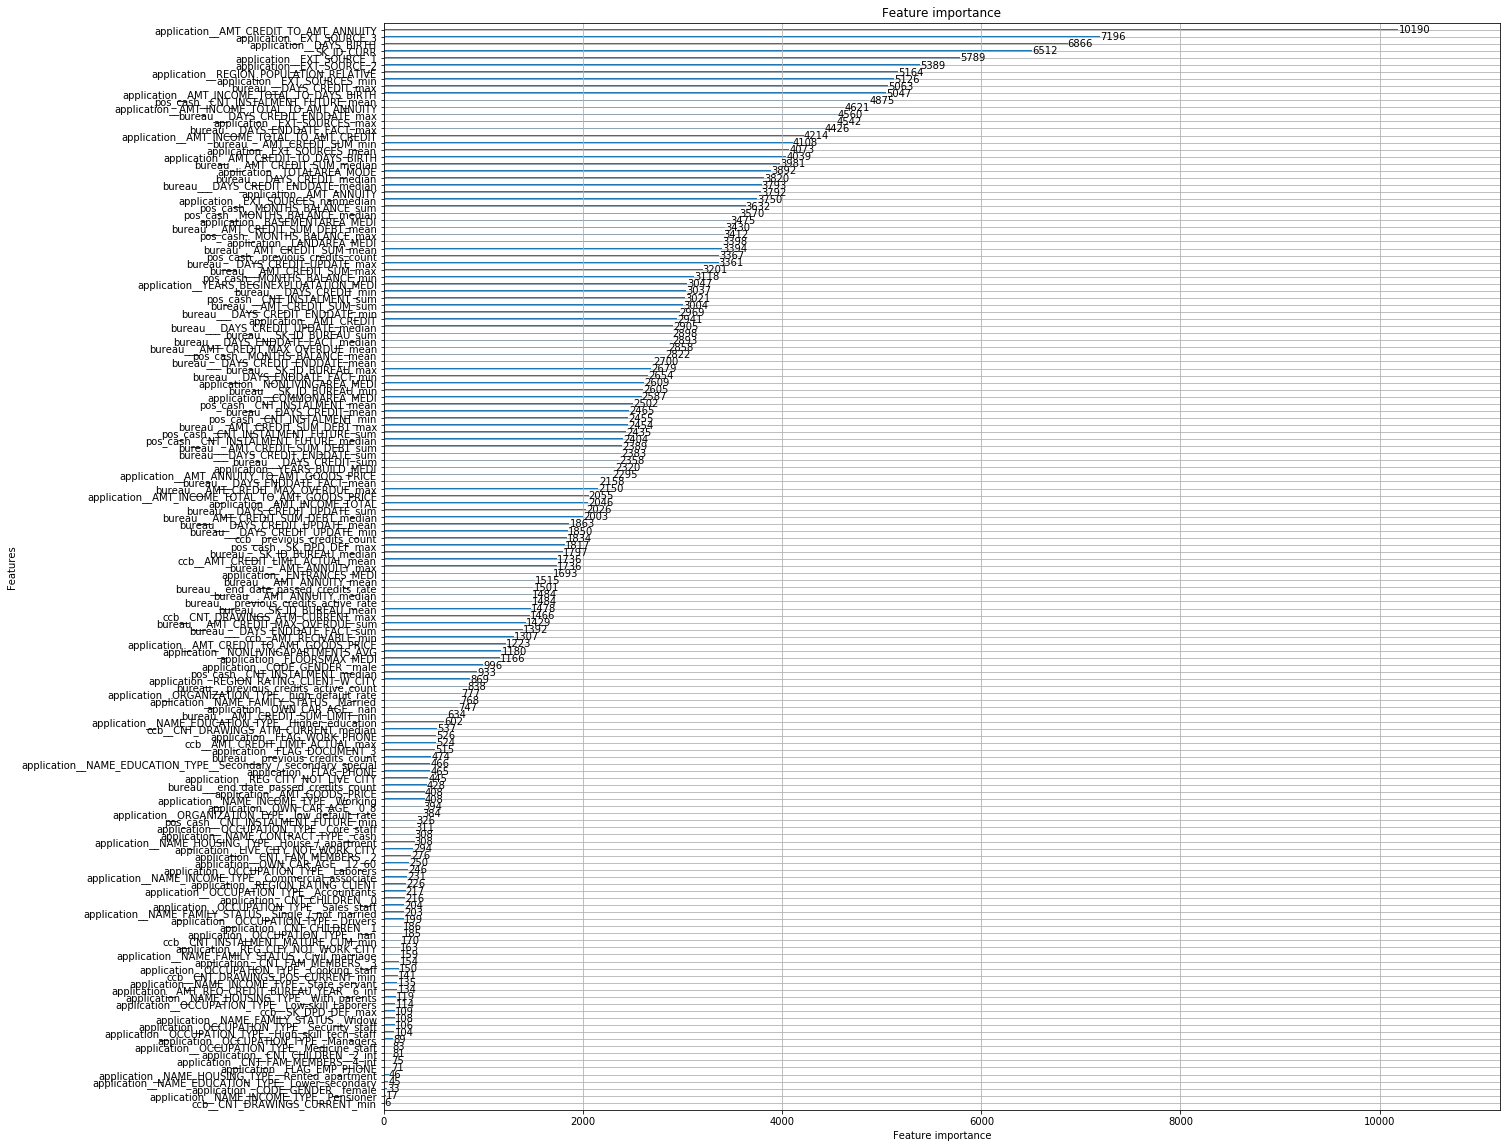

Fold 1, VALID AUC: 0.7724
[400]	training's auc: 0.76991	training's binary_logloss: 0.24412	valid_1's auc: 0.751567	valid_1's binary_logloss: 0.247957
[800]	training's auc: 0.794498	training's binary_logloss: 0.234934	valid_1's auc: 0.76561	valid_1's binary_logloss: 0.242859
[1200]	training's auc: 0.810372	training's binary_logloss: 0.229166	valid_1's auc: 0.771067	valid_1's binary_logloss: 0.240948
[1600]	training's auc: 0.823842	training's binary_logloss: 0.224481	valid_1's auc: 0.77313	valid_1's binary_logloss: 0.240197
[2000]	training's auc: 0.836303	training's binary_logloss: 0.220271	valid_1's auc: 0.774482	valid_1's binary_logloss: 0.239734
[2400]	training's auc: 0.847172	training's binary_logloss: 0.216443	valid_1's auc: 0.775132	valid_1's binary_logloss: 0.239491
[2800]	training's auc: 0.857173	training's binary_logloss: 0.212828	valid_1's auc: 0.775627	valid_1's binary_logloss: 0.239317
[3200]	training's auc: 0.866311	training's binary_logloss: 0.209388	valid_1's auc: 0.775883

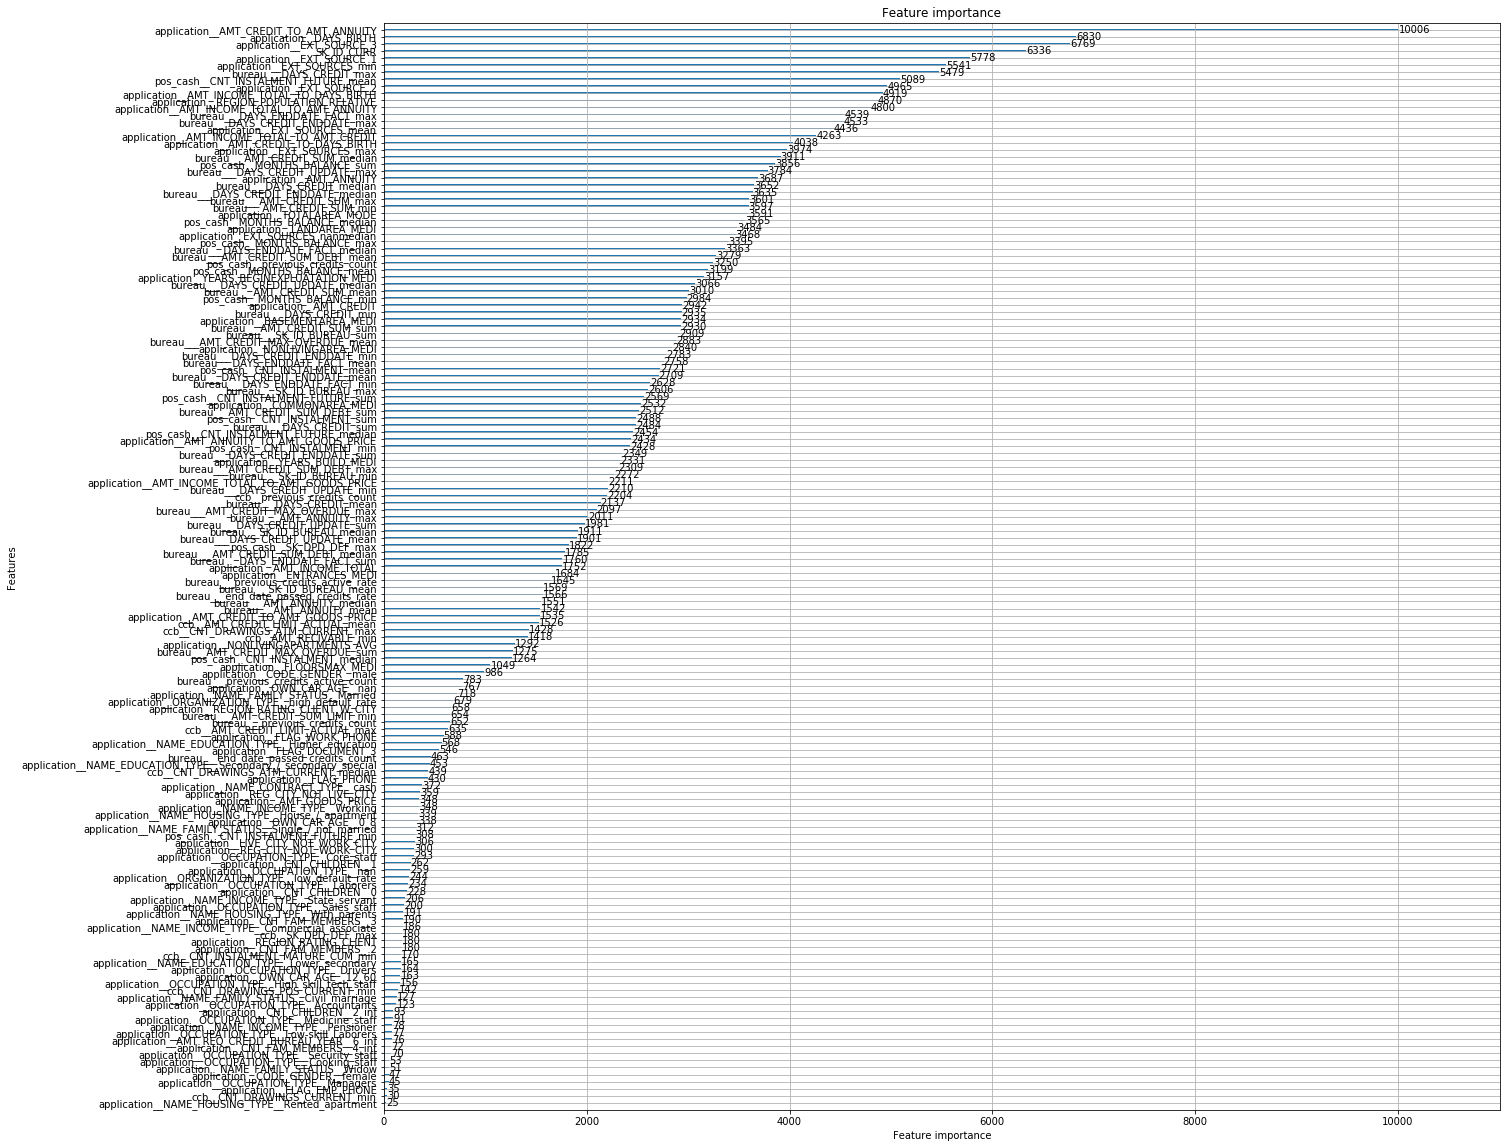

Fold 2, VALID AUC: 0.7729
[400]	training's auc: 0.768543	training's binary_logloss: 0.244646	valid_1's auc: 0.7514	valid_1's binary_logloss: 0.246558
[800]	training's auc: 0.792401	training's binary_logloss: 0.235669	valid_1's auc: 0.766726	valid_1's binary_logloss: 0.24124
[1200]	training's auc: 0.809036	training's binary_logloss: 0.2298	valid_1's auc: 0.773273	valid_1's binary_logloss: 0.239074
[1600]	training's auc: 0.82315	training's binary_logloss: 0.225051	valid_1's auc: 0.775718	valid_1's binary_logloss: 0.238265
[2000]	training's auc: 0.835512	training's binary_logloss: 0.220875	valid_1's auc: 0.776807	valid_1's binary_logloss: 0.237922
[2400]	training's auc: 0.846692	training's binary_logloss: 0.217003	valid_1's auc: 0.777424	valid_1's binary_logloss: 0.237678
[2800]	training's auc: 0.85655	training's binary_logloss: 0.2134	valid_1's auc: 0.777723	valid_1's binary_logloss: 0.237551
[3200]	training's auc: 0.865216	training's binary_logloss: 0.210038	valid_1's auc: 0.777918	vali

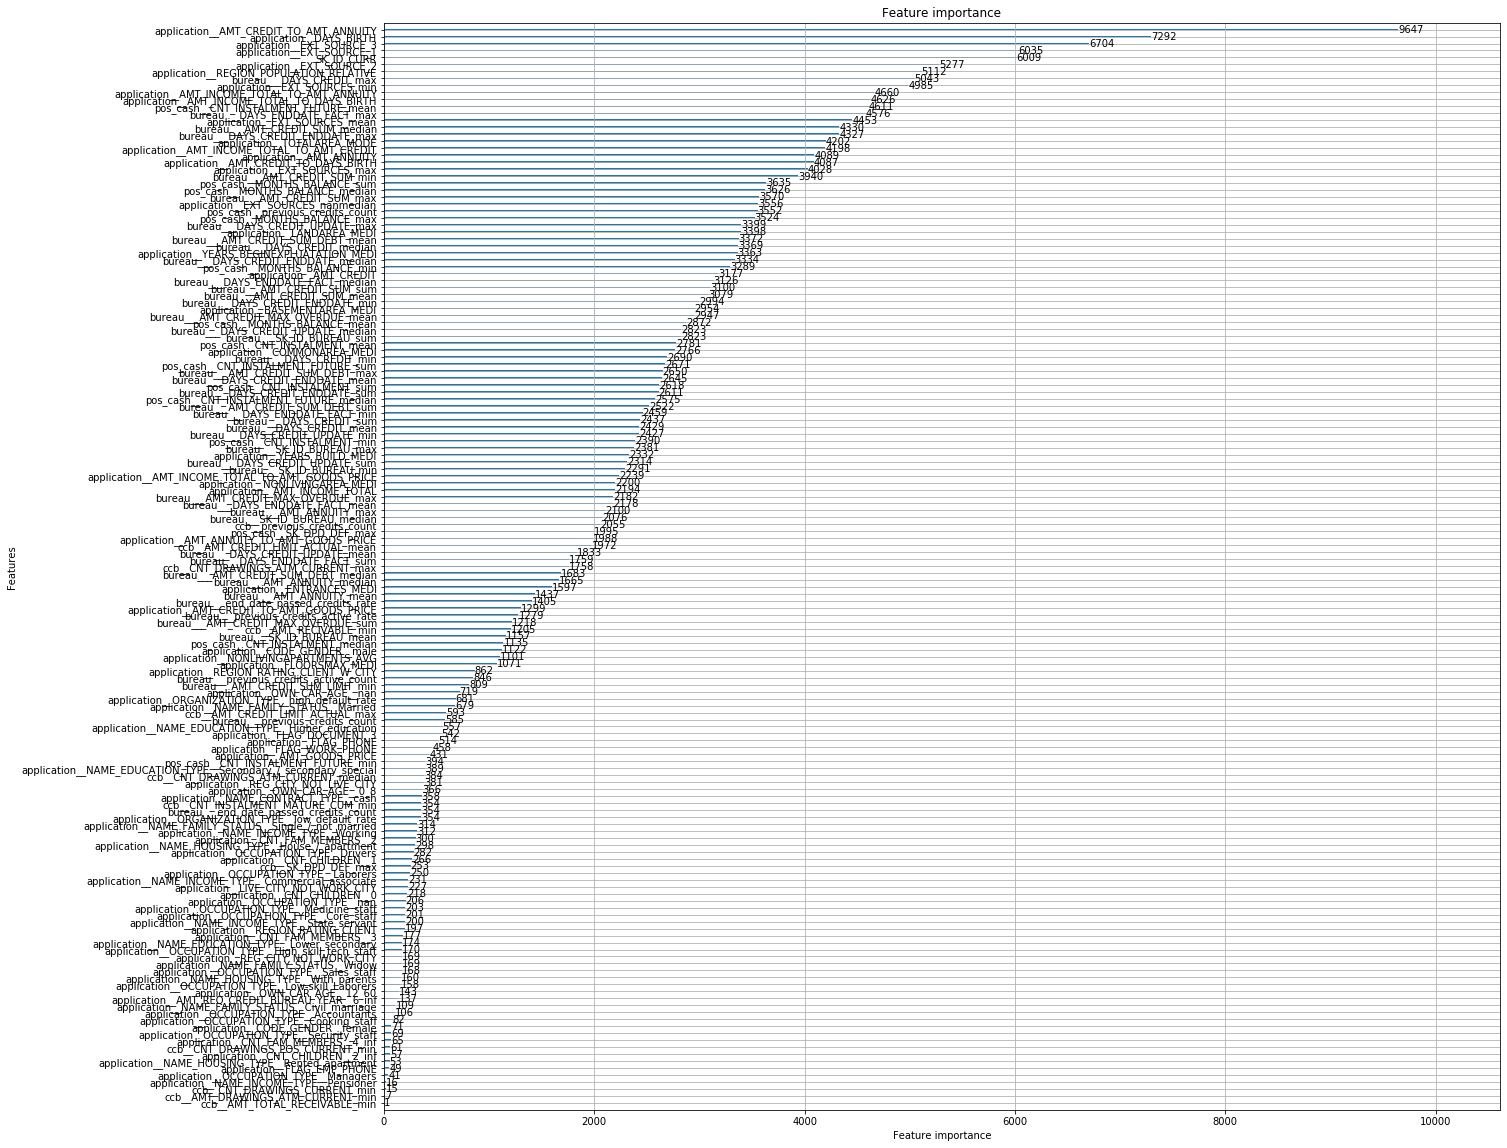

Fold 3, VALID AUC: 0.7765
[400]	training's auc: 0.770358	training's binary_logloss: 0.244373	valid_1's auc: 0.750699	valid_1's binary_logloss: 0.246958
[800]	training's auc: 0.794579	training's binary_logloss: 0.235122	valid_1's auc: 0.762777	valid_1's binary_logloss: 0.242137
[1200]	training's auc: 0.810817	training's binary_logloss: 0.229242	valid_1's auc: 0.76741	valid_1's binary_logloss: 0.240427
[1600]	training's auc: 0.824079	training's binary_logloss: 0.224595	valid_1's auc: 0.769094	valid_1's binary_logloss: 0.239779
[2000]	training's auc: 0.8358	training's binary_logloss: 0.220505	valid_1's auc: 0.77006	valid_1's binary_logloss: 0.239494
[2400]	training's auc: 0.846522	training's binary_logloss: 0.216704	valid_1's auc: 0.770516	valid_1's binary_logloss: 0.239332
[2800]	training's auc: 0.856223	training's binary_logloss: 0.213151	valid_1's auc: 0.77079	valid_1's binary_logloss: 0.239235
[3200]	training's auc: 0.865387	training's binary_logloss: 0.209757	valid_1's auc: 0.770981	

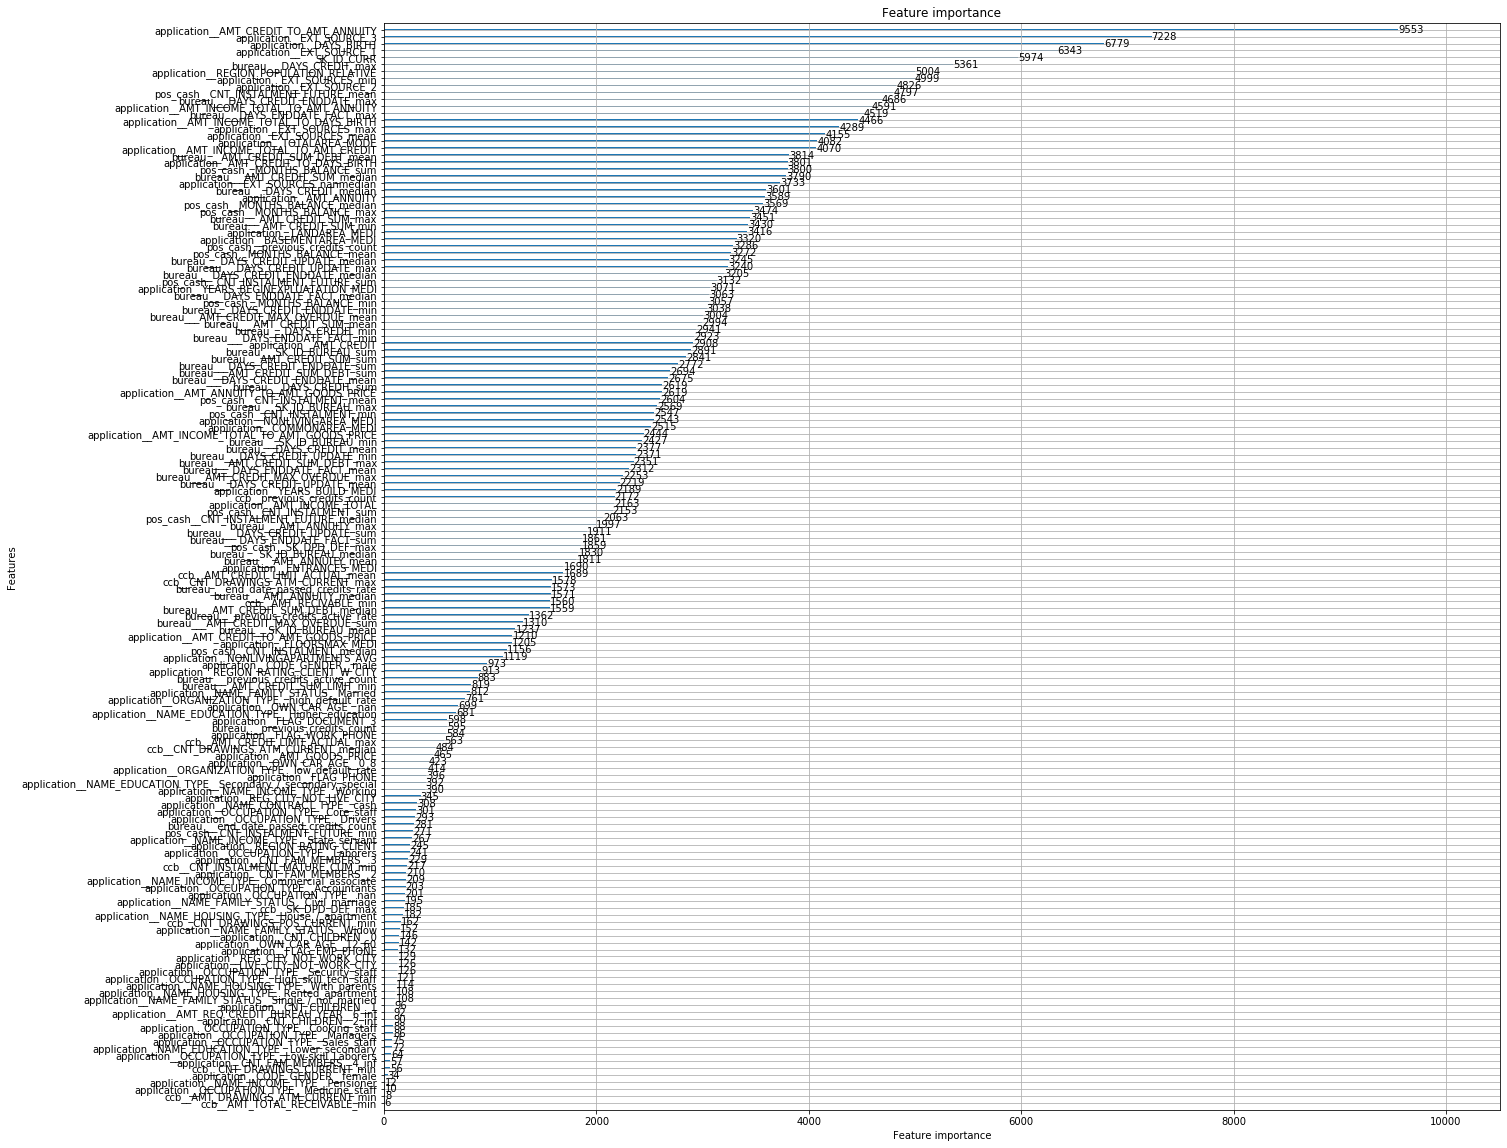

Fold 4, VALID AUC: 0.7693
[400]	training's auc: 0.768433	training's binary_logloss: 0.244047	valid_1's auc: 0.754388	valid_1's binary_logloss: 0.248909
[800]	training's auc: 0.792751	training's binary_logloss: 0.235046	valid_1's auc: 0.767596	valid_1's binary_logloss: 0.24376
[1200]	training's auc: 0.808828	training's binary_logloss: 0.229284	valid_1's auc: 0.772353	valid_1's binary_logloss: 0.24192
[1600]	training's auc: 0.823064	training's binary_logloss: 0.224502	valid_1's auc: 0.775544	valid_1's binary_logloss: 0.240882
[2000]	training's auc: 0.835686	training's binary_logloss: 0.220322	valid_1's auc: 0.776764	valid_1's binary_logloss: 0.240457
[2400]	training's auc: 0.846469	training's binary_logloss: 0.216508	valid_1's auc: 0.777526	valid_1's binary_logloss: 0.240206
[2800]	training's auc: 0.856243	training's binary_logloss: 0.212949	valid_1's auc: 0.778177	valid_1's binary_logloss: 0.240021
[3200]	training's auc: 0.865073	training's binary_logloss: 0.209589	valid_1's auc: 0.7786

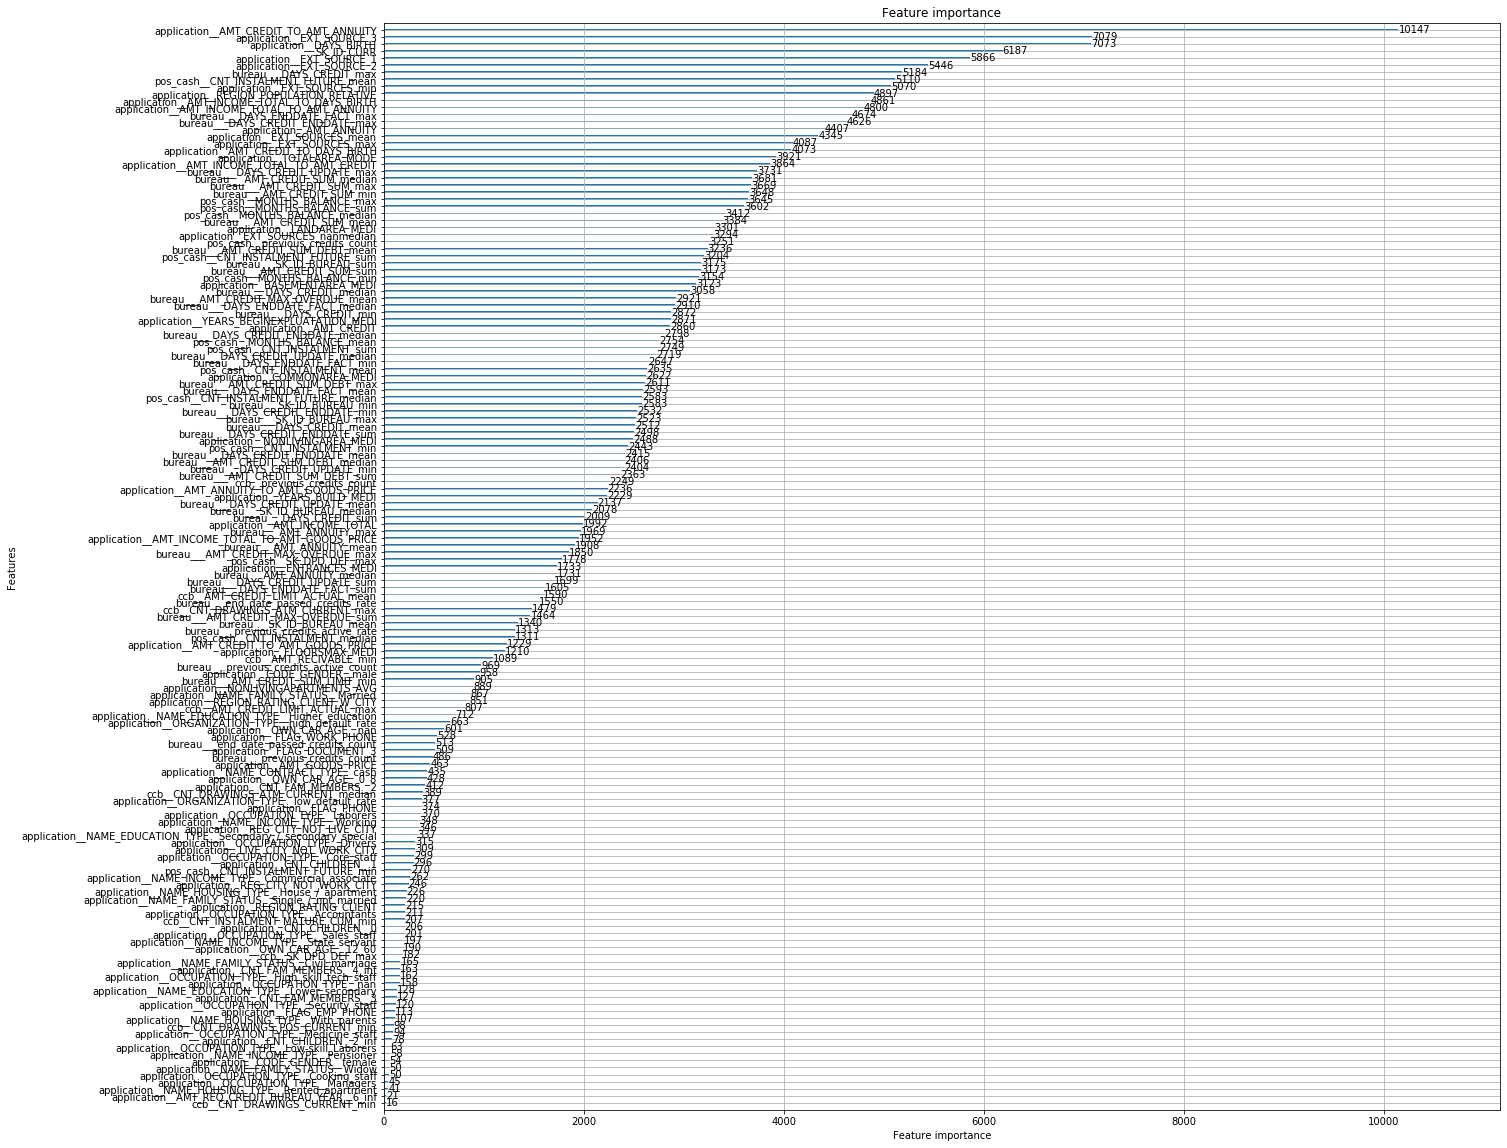

Fold 5, VALID AUC: 0.7785
Full TRAIN AUC score 0.7738881149300054
TEST AUC score 0.7775358615395743


In [7]:
lgbm_params = {
    'boosting_type':'gbdt',
    'n_estimators':10000, 
    'learning_rate':0.005,
    'max_depth': 10,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}
kfold_lightgbm(X_TRAIN, X_TEST, 5, lgbm_params=lgbm_params)

[400]	training's auc: 0.764178	training's binary_logloss: 0.24571	valid_1's auc: 0.752294	valid_1's binary_logloss: 0.251837
[800]	training's auc: 0.784894	training's binary_logloss: 0.237829	valid_1's auc: 0.765744	valid_1's binary_logloss: 0.246476
[1200]	training's auc: 0.797914	training's binary_logloss: 0.233111	valid_1's auc: 0.771766	valid_1's binary_logloss: 0.244314
[1600]	training's auc: 0.808609	training's binary_logloss: 0.229414	valid_1's auc: 0.774986	valid_1's binary_logloss: 0.243194
[2000]	training's auc: 0.817968	training's binary_logloss: 0.226286	valid_1's auc: 0.776413	valid_1's binary_logloss: 0.242687
[2400]	training's auc: 0.826268	training's binary_logloss: 0.223506	valid_1's auc: 0.776866	valid_1's binary_logloss: 0.242495
[2800]	training's auc: 0.833786	training's binary_logloss: 0.220899	valid_1's auc: 0.777177	valid_1's binary_logloss: 0.242379
[3200]	training's auc: 0.841076	training's binary_logloss: 0.218351	valid_1's auc: 0.777553	valid_1's binary_loglo

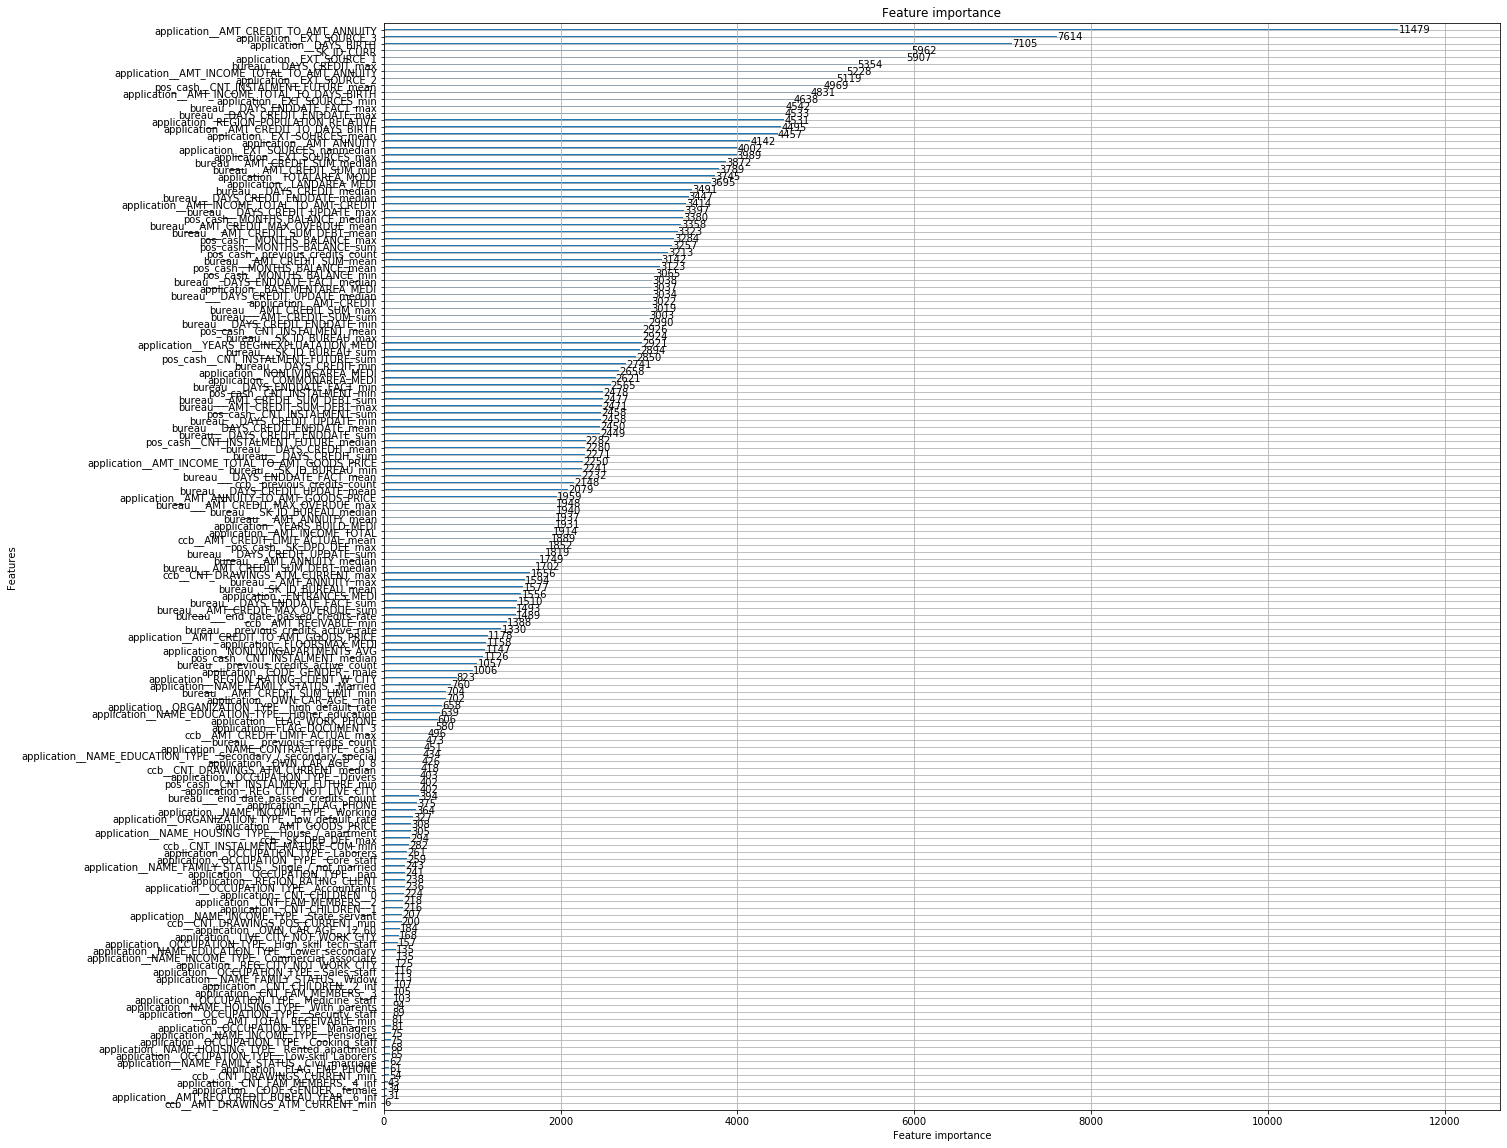

Fold 1, VALID AUC: 0.7794
[400]	training's auc: 0.764013	training's binary_logloss: 0.24629	valid_1's auc: 0.75352	valid_1's binary_logloss: 0.24959
[800]	training's auc: 0.784633	training's binary_logloss: 0.238398	valid_1's auc: 0.766863	valid_1's binary_logloss: 0.244363
[1200]	training's auc: 0.797904	training's binary_logloss: 0.23367	valid_1's auc: 0.772393	valid_1's binary_logloss: 0.242353
[1600]	training's auc: 0.808725	training's binary_logloss: 0.22998	valid_1's auc: 0.775196	valid_1's binary_logloss: 0.241409
[2000]	training's auc: 0.818178	training's binary_logloss: 0.226752	valid_1's auc: 0.777041	valid_1's binary_logloss: 0.240795
[2400]	training's auc: 0.826509	training's binary_logloss: 0.223915	valid_1's auc: 0.777887	valid_1's binary_logloss: 0.240512
[2800]	training's auc: 0.834291	training's binary_logloss: 0.221291	valid_1's auc: 0.778394	valid_1's binary_logloss: 0.240351
[3200]	training's auc: 0.841379	training's binary_logloss: 0.218772	valid_1's auc: 0.778713	

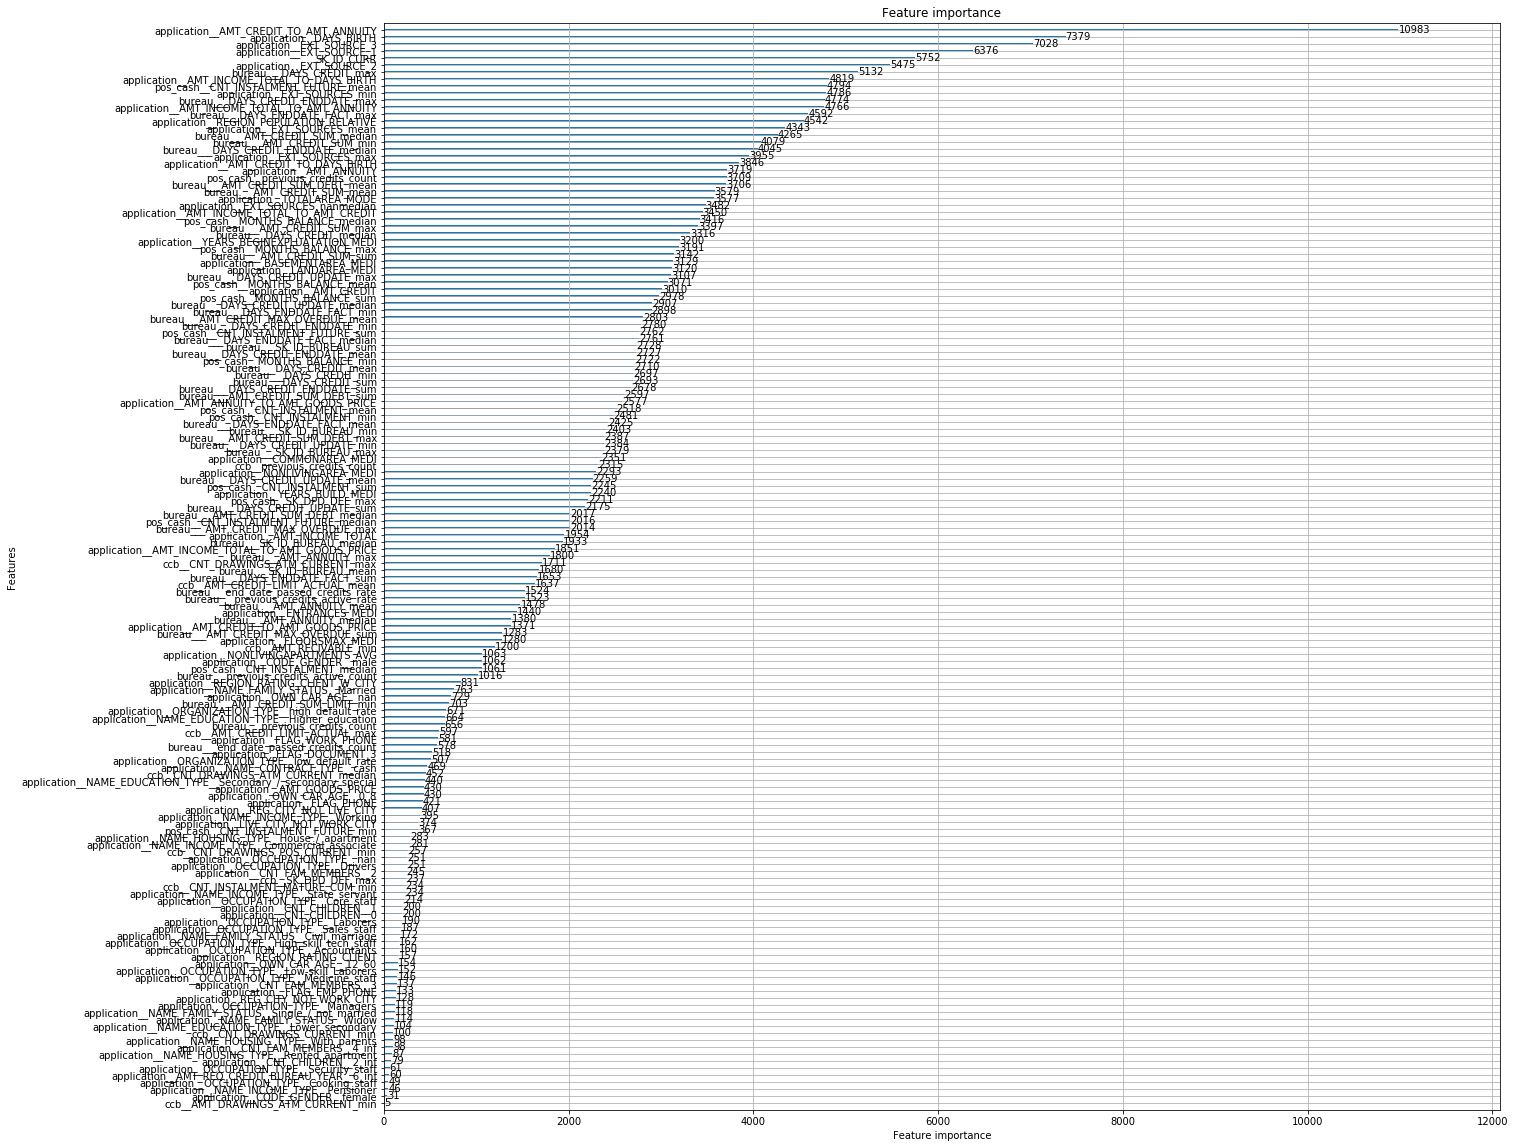

Fold 2, VALID AUC: 0.7791
[400]	training's auc: 0.763961	training's binary_logloss: 0.246011	valid_1's auc: 0.751352	valid_1's binary_logloss: 0.250582
[800]	training's auc: 0.784369	training's binary_logloss: 0.238172	valid_1's auc: 0.764876	valid_1's binary_logloss: 0.245661
[1200]	training's auc: 0.797218	training's binary_logloss: 0.233462	valid_1's auc: 0.770683	valid_1's binary_logloss: 0.243703
[1600]	training's auc: 0.807916	training's binary_logloss: 0.229718	valid_1's auc: 0.774192	valid_1's binary_logloss: 0.242618
[2000]	training's auc: 0.817047	training's binary_logloss: 0.226638	valid_1's auc: 0.775554	valid_1's binary_logloss: 0.242199
[2400]	training's auc: 0.825229	training's binary_logloss: 0.223877	valid_1's auc: 0.776307	valid_1's binary_logloss: 0.241988
[2800]	training's auc: 0.833143	training's binary_logloss: 0.221228	valid_1's auc: 0.776887	valid_1's binary_logloss: 0.241824
[3200]	training's auc: 0.840882	training's binary_logloss: 0.218625	valid_1's auc: 0.77

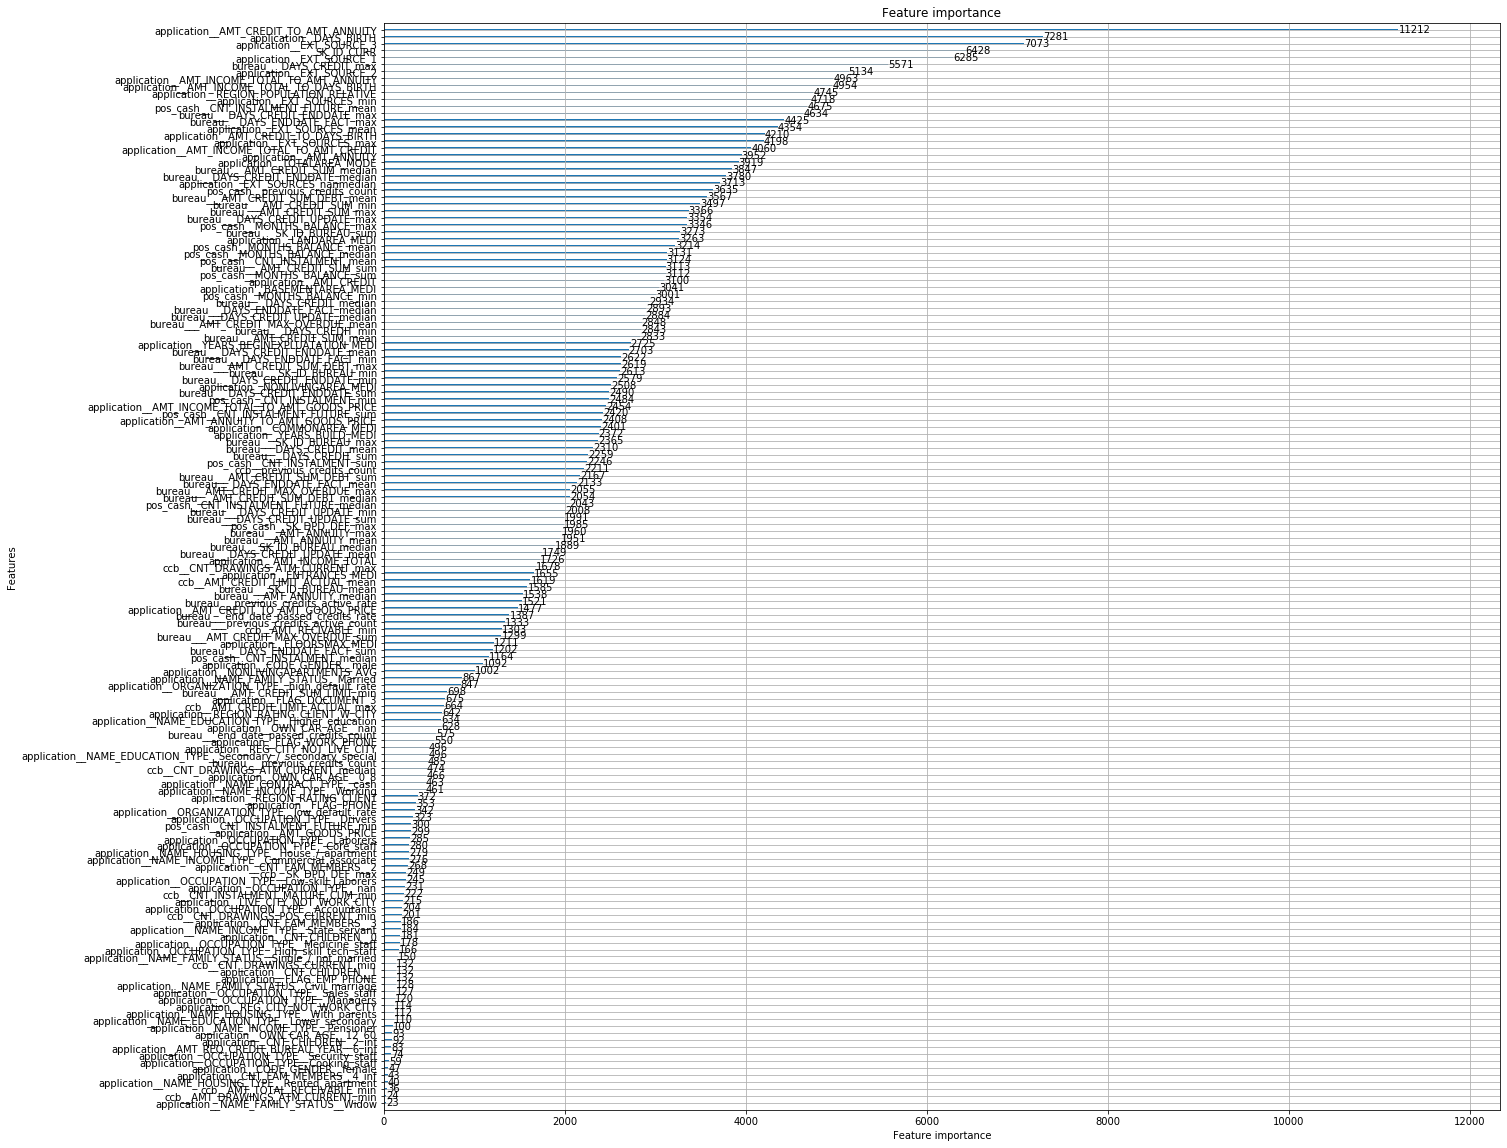

Fold 3, VALID AUC: 0.7793
[400]	training's auc: 0.764956	training's binary_logloss: 0.246669	valid_1's auc: 0.746512	valid_1's binary_logloss: 0.248177
[800]	training's auc: 0.78556	training's binary_logloss: 0.238797	valid_1's auc: 0.761527	valid_1's binary_logloss: 0.242784
[1200]	training's auc: 0.798326	training's binary_logloss: 0.234105	valid_1's auc: 0.767631	valid_1's binary_logloss: 0.240675
[1600]	training's auc: 0.808602	training's binary_logloss: 0.230488	valid_1's auc: 0.770356	valid_1's binary_logloss: 0.239731
[2000]	training's auc: 0.817854	training's binary_logloss: 0.227409	valid_1's auc: 0.771434	valid_1's binary_logloss: 0.239318
[2400]	training's auc: 0.826643	training's binary_logloss: 0.224569	valid_1's auc: 0.772277	valid_1's binary_logloss: 0.239045
[2800]	training's auc: 0.834377	training's binary_logloss: 0.221958	valid_1's auc: 0.772694	valid_1's binary_logloss: 0.238895
[3200]	training's auc: 0.84163	training's binary_logloss: 0.219452	valid_1's auc: 0.7729

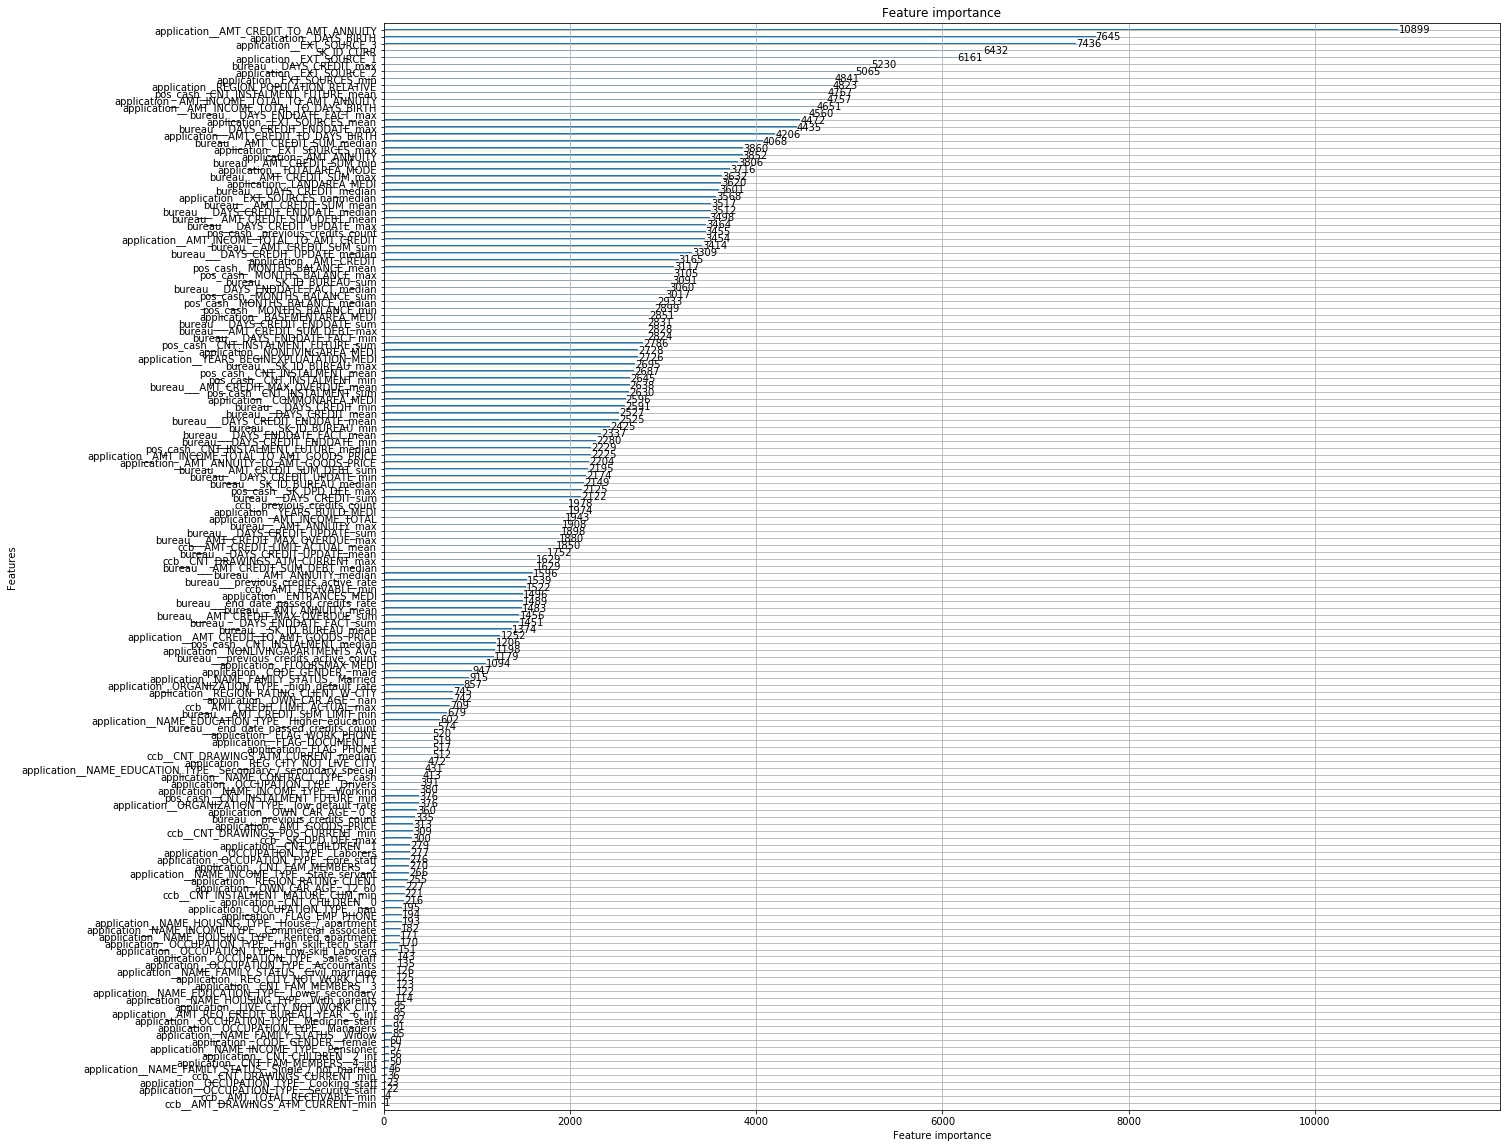

Fold 4, VALID AUC: 0.7742
[400]	training's auc: 0.763719	training's binary_logloss: 0.24689	valid_1's auc: 0.756684	valid_1's binary_logloss: 0.247079
[800]	training's auc: 0.784082	training's binary_logloss: 0.239072	valid_1's auc: 0.770213	valid_1's binary_logloss: 0.241713
[1200]	training's auc: 0.79731	training's binary_logloss: 0.234296	valid_1's auc: 0.775911	valid_1's binary_logloss: 0.239555
[1600]	training's auc: 0.807856	training's binary_logloss: 0.230646	valid_1's auc: 0.778398	valid_1's binary_logloss: 0.238618
[2000]	training's auc: 0.816973	training's binary_logloss: 0.227572	valid_1's auc: 0.779378	valid_1's binary_logloss: 0.23826
[2400]	training's auc: 0.825225	training's binary_logloss: 0.224764	valid_1's auc: 0.77988	valid_1's binary_logloss: 0.238077
[2800]	training's auc: 0.832941	training's binary_logloss: 0.222113	valid_1's auc: 0.780248	valid_1's binary_logloss: 0.237942
[3200]	training's auc: 0.840369	training's binary_logloss: 0.219575	valid_1's auc: 0.780508

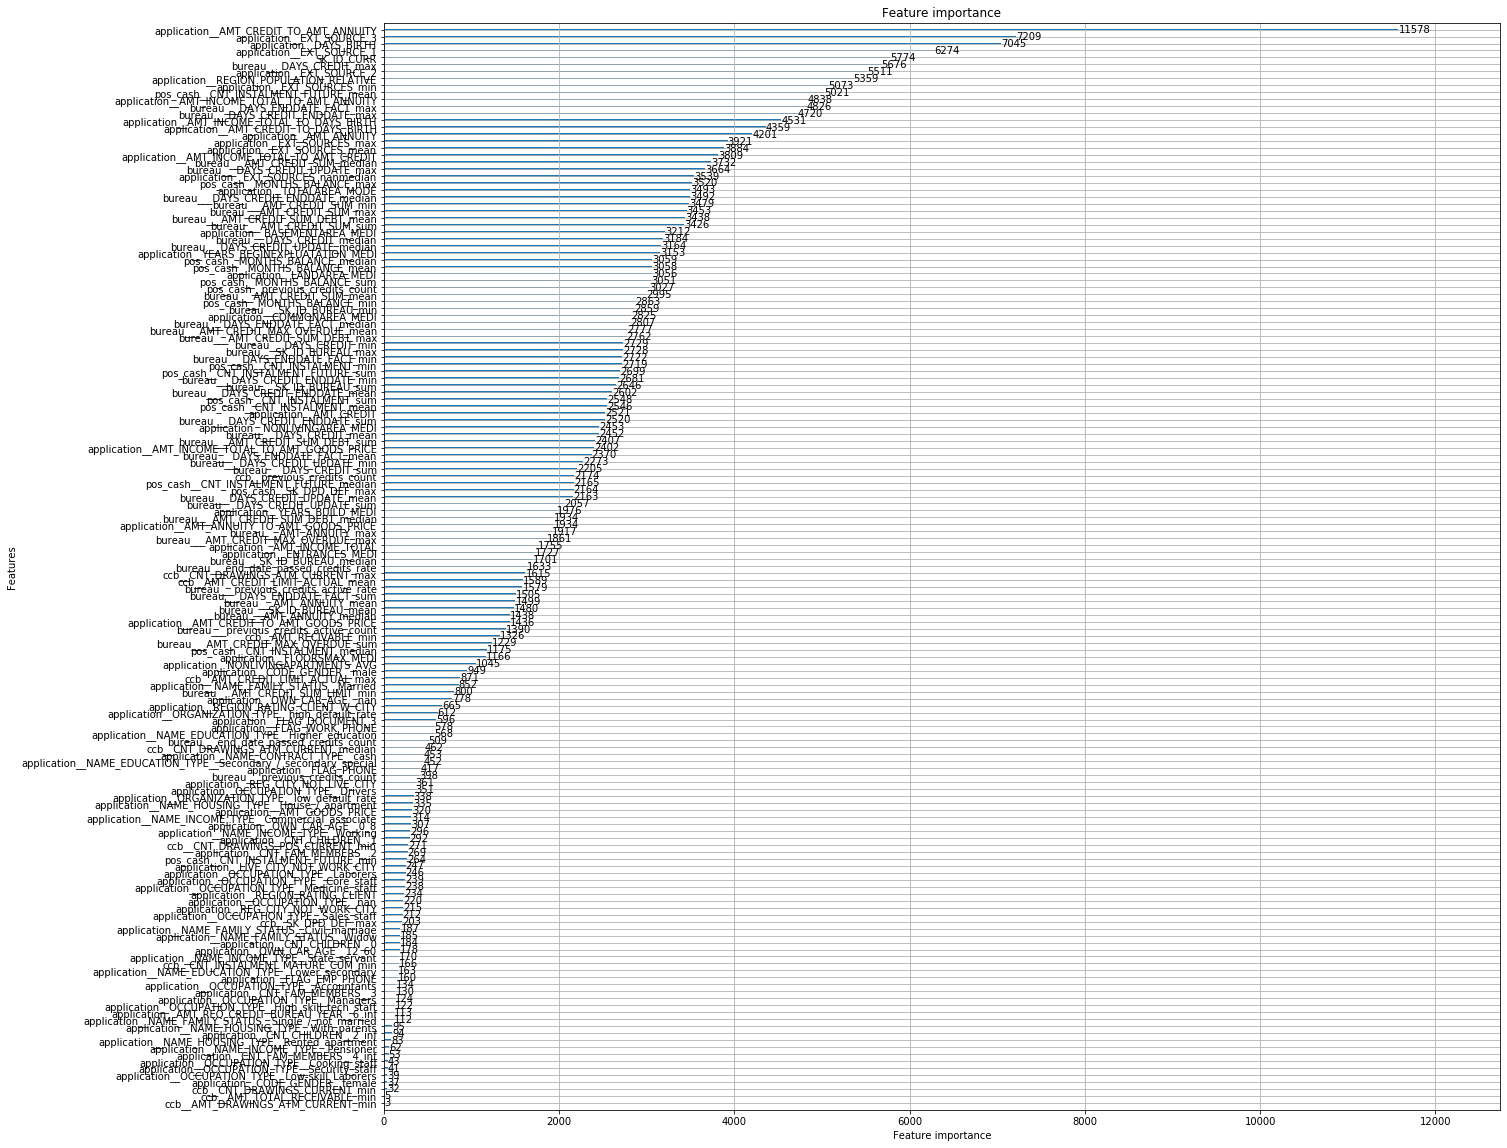

Fold 5, VALID AUC: 0.7807
Full TRAIN AUC score 0.7785115481078615


ValueError: array length 307511 does not match index length 48744

In [13]:
application_mod_df['TARGET'] = application_df['TARGET']

lgbm_params = {
    'boosting_type':'gbdt',
    'n_estimators':10000, 
    'learning_rate':0.005,
    'max_depth': 10,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}
ans = kfold_lightgbm(application_mod_df, application_mod_test_df, 5, lgbm_params=lgbm_params, real_test=True)

In [ ]:
ans.to_csv('a-b-c-p.csv', index=False)